In [2]:
suppressMessages(library(ArchR))
library(parallel)
ss <- function(x, pattern, slot = 1, ...) { sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)
suppressMessages(library(Seurat))
suppressMessages(library(SingleCellExperiment))
library(tidyverse)

In [3]:
##################################
### set Arrow File parameters ####
addArchRThreads(threads = 12)

##################################
### load rheMac10 ArchR genome ###
GENOMEDIR='/home/bnphan/resources/genomes/rheMac10'
load(file.path(GENOMEDIR,'rheMac10_liftoff_GRCh38.p13_ArchR_annotations.rda'))

Setting default number of Parallel threads to 12.



In [4]:
PROJDIR='../../../data/tidy_data/ArchRProjects'
proj = loadArchRProject(file.path(PROJDIR,'Macaque_DorsalHorn_scATAC'), showLogo = FALSE)
projNeuron = loadArchRProject(file.path(PROJDIR,'Macaque_scATAC_DorsalHorn_neuron'), showLogo = FALSE)
projGlia = loadArchRProject(file.path(PROJDIR,'Macaque_scATAC_DorsalHorn_glia'), showLogo = FALSE)

Successfully loaded ArchRProject!

Successfully loaded ArchRProject!

Successfully loaded ArchRProject!



# Add predictedRNA2ATAC co-clustering labels from sub-analyses

In [5]:
df_Neuron = getCellColData(projNeuron)
df_Glia = getCellColData(projGlia)

columns = names(getCellColData(projGlia))
df_label = rbind(df_Neuron[,columns],df_Glia[,columns] )
head(df_label)
print(getCellColData(proj))

DataFrame with 6 rows and 27 columns
                                        Sample TSSEnrichment ReadsInTSS
                                   <character>     <numeric>  <numeric>
DH-1_SEA1346A1#CAAACCTGATACTTTC DH-1_SEA1346A1        14.364       6572
DH-1_SEA1346A1#CGCGTTGGAGTGGTGA DH-1_SEA1346A1         9.010       3458
DH-1_SEA1346A1#GCATCAATGAGCGCTC DH-1_SEA1346A1        14.883       5667
DH-1_SEA1346A1#CTGTCGTTGCTTCAAG DH-1_SEA1346A1        26.830      11151
DH-1_SEA1346A1#TCGCCGAGATAAGCAA DH-1_SEA1346A1        21.666       9869
DH-1_SEA1346A1#GCAGGTCTGACTAGGG DH-1_SEA1346A1        12.713       6086
                                ReadsInPromoter PromoterRatio    PassQC
                                      <numeric>     <numeric> <numeric>
DH-1_SEA1346A1#CAAACCTGATACTTTC           33398      0.169640         1
DH-1_SEA1346A1#CGCGTTGGAGTGGTGA           20955      0.110136         1
DH-1_SEA1346A1#GCATCAATGAGCGCTC           28640      0.172501         1
DH-1_SEA1346A1#CTGTCGTTGCTT

DataFrame with 81077 rows and 24 columns
                                          Sample TSSEnrichment ReadsInTSS
                                     <character>     <numeric>  <numeric>
DH-1_SEA1346A1#CAAACCTGATACTTTC   DH-1_SEA1346A1        14.364       6572
DH-1_SEA1346A1#CGCGTTGGAGTGGTGA   DH-1_SEA1346A1         9.010       3458
DH-1_SEA1346A1#TAGTTGCGACGGTACC   DH-1_SEA1346A1        19.339       8555
DH-1_SEA1346A1#TAGTGCTGATAGGTTC   DH-1_SEA1346A1        22.142      10712
DH-1_SEA1346A1#GCATCAATGAGCGCTC   DH-1_SEA1346A1        14.883       5667
...                                          ...           ...        ...
DH-9_SEA2253A45#CAGTATCTTAATCGCG DH-9_SEA2253A45        25.941        393
DH-9_SEA2253A45#TTTCTGATGGGCATTT DH-9_SEA2253A45        16.640        563
DH-9_SEA2253A45#CGTGTTGATTTCCGCG DH-9_SEA2253A45        19.059        385
DH-9_SEA2253A45#GACACGCACCGATGTT DH-9_SEA2253A45         9.432        181
DH-9_SEA2253A45#GTGGTTAACGCTACGC DH-9_SEA2253A45        22.835        5

In [6]:
## transfer labels via cell barcodes
df_label = df_label %>% as.data.frame() %>%
    mutate(predictedGroup_RNA2ATACCo = ifelse(grepl('EXC|INH', Celltype1), predictedGroup_RNA2ATACCo, Celltype1))
df_label = df_label[getCellNames(proj),]
proj <- addCellColData(ArchRProj = proj, data = df_label$predictedGroup_RNA2ATACCo,
    cells = rownames(df_label), name = "predictedGroup_RNA2ATACCo", force = TRUE)
proj <- addCellColData(ArchRProj = proj, data = df_label$predictedGroup_RNA2ATACCo,
    cells = rownames(df_label), name = "Celltype1", force = TRUE)



Overriding previous entry for predictedGroup_RNA2ATACCo

Overriding previous entry for Celltype1



In [7]:
table(proj$Celltype2)

< table of extent 0 >

In [8]:
## subset to cells with integrated labels
idxPass <- which(!is.na(proj$predictedGroup_RNA2ATACCo) & 
                 proj$predictedGroup_RNA2ATACCo %ni% c('Drop', 'NA.', 'TH')) # too few cluster

cellsPass <- proj$cellNames[idxPass]
proj = proj[cellsPass, ]

In [9]:
getCellColData(proj)

DataFrame with 81077 rows and 24 columns
                                          Sample TSSEnrichment ReadsInTSS
                                     <character>     <numeric>  <numeric>
DH-1_SEA1346A1#CAAACCTGATACTTTC   DH-1_SEA1346A1        14.364       6572
DH-1_SEA1346A1#CGCGTTGGAGTGGTGA   DH-1_SEA1346A1         9.010       3458
DH-1_SEA1346A1#TAGTTGCGACGGTACC   DH-1_SEA1346A1        19.339       8555
DH-1_SEA1346A1#TAGTGCTGATAGGTTC   DH-1_SEA1346A1        22.142      10712
DH-1_SEA1346A1#GCATCAATGAGCGCTC   DH-1_SEA1346A1        14.883       5667
...                                          ...           ...        ...
DH-9_SEA2253A45#CAGTATCTTAATCGCG DH-9_SEA2253A45        25.941        393
DH-9_SEA2253A45#TTTCTGATGGGCATTT DH-9_SEA2253A45        16.640        563
DH-9_SEA2253A45#CGTGTTGATTTCCGCG DH-9_SEA2253A45        19.059        385
DH-9_SEA2253A45#GACACGCACCGATGTT DH-9_SEA2253A45         9.432        181
DH-9_SEA2253A45#GTGGTTAACGCTACGC DH-9_SEA2253A45        22.835        5

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-36f257287d530-Date-2022-07-18_Time-11-07-15.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-36f257287d530-Date-2022-07-18_Time-11-07-15.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-36f2569ae2a9b-Date-2022-07-18_Time-11-07-22.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-36f2569ae2a9b-Date-2022-07-18_Time-11-07-22.log



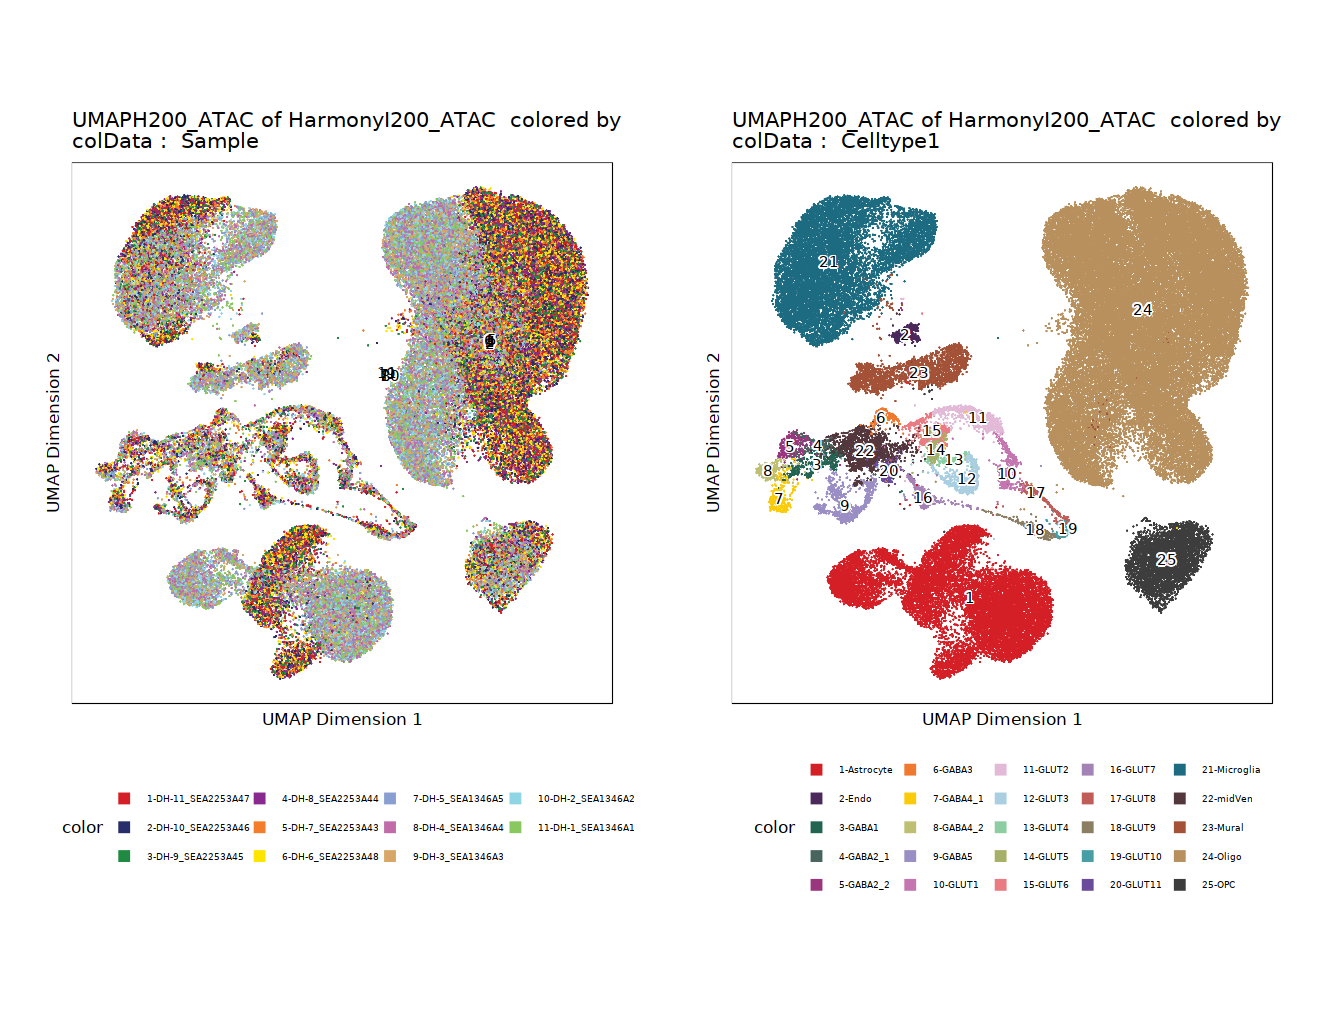

In [10]:
## make UMAP plots
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "Sample", embedding = "UMAPH200_ATAC")

p2 <- plotEmbedding(proj, colorBy = "cellColData", 
                    name = "Celltype1", embedding = "UMAPH200_ATAC")


ggAlignPlots(p1, p2,  type = "h")

In [11]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

# Call peaks using integrated clusters

In [12]:
library(BSgenome.Mmulatta.UCSC.rheMac10)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer



In [17]:
# make group coverage, call peaks, and 
proj<-addGroupCoverages(proj, groupBy="predictedGroup_RNA2ATACCo", 
                        minReplicates = 5, maxReplicates = 11, force = TRUE,
                        minCells = 40, maxCells = 1000)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-36f2528dd710a-Date-2022-07-19_Time-11-00-36.log
If there is an issue, please report to github with logFile!

Astrocyte (1 of 25) : CellGroups N = 11

Endo (2 of 25) : CellGroups N = 6

GABA1 (3 of 25) : CellGroups N = 9

GABA2_1 (4 of 25) : CellGroups N = 5

GABA2_2 (5 of 25) : CellGroups N = 5

GABA3 (6 of 25) : CellGroups N = 5

GABA4_1 (7 of 25) : CellGroups N = 5

GABA4_2 (8 of 25) : CellGroups N = 5

GABA5 (9 of 25) : CellGroups N = 11

GLUT1 (10 of 25) : CellGroups N = 9

GLUT2 (11 of 25) : CellGroups N = 11

GLUT3 (12 of 25) : CellGroups N = 11

GLUT4 (13 of 25) : CellGroups N = 5

GLUT5 (14 of 25) : CellGroups N = 5

GLUT6 (15 of 25) : CellGroups N = 5

GLUT7 (16 of 25) : CellGroups N = 6

GLUT8 (17 of 25) : CellGroups N = 5

GLUT9 (18 of 25) : CellGroups N = 5

GLUT10 (19 of 25) : CellGroups N = 5

GLUT11 (20 of 25) : CellGroups N = 5

Microglia (21 of 25) : CellGroups N = 11

midVen (22 of 25) : CellGroups N = 11

Mural (23

In [19]:
# call peaks 
proj<-addReproduciblePeakSet(proj, groupBy = "predictedGroup_RNA2ATACCo", reproducibility = "(n + 1)/2",
                             plot = FALSE, genomeSize = 2.7e9)

Searching For MACS2..

Found with $path!

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-36f2512e79b11-Date-2022-07-20_Time-09-37-06.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-07-20 09:37:07 : Peak Calling Parameters!, 0.03 mins elapsed.



              Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
Astrocyte Astrocyte  12964       8984          11  634 1000   150000
Endo           Endo    366        366           6   52   70   150000
GABA1         GABA1    454        454           9   41  105   150000
GABA2_1     GABA2_1    200        200           5   40   40   100000
GABA2_2     GABA2_2    312        312           5   60   63   150000
GABA3         GABA3    245        245           5   49   49   122500
GABA4_1     GABA4_1    382        382           5   41  199   150000
GABA4_2     GABA4_2    323        323           5   41   79   150000
GABA5         GABA5    790        790          11   53   91   150000
GLUT1         GLUT1    502        502           9   44  100   150000
GLUT2         GLUT2    687        687          11   53   76   150000
GLUT3         GLUT3    630        630          11   45   73   150000
GLUT4         GLUT4    154        124           5   40   40    62000
GLUT5         GLUT5    344        

2022-07-20 09:37:07 : Batching Peak Calls!, 0.03 mins elapsed.

2022-07-20 09:37:07 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-07-20 15:18:29 : Identifying Reproducible Peaks!, 341.395 mins elapsed.

2022-07-20 15:26:20 : Creating Union Peak Set!, 349.236 mins elapsed.

Converged after 12 iterations!

2022-07-20 15:26:36 : Finished Creating Union Peak Set (604327)!, 349.499 mins elapsed.



In [24]:
# add peak counts matrix 
proj <- addPeakMatrix(proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-36f2515e27a56-Date-2022-07-20_Time-18-57-37.log
If there is an issue, please report to github with logFile!

2022-07-20 18:57:37 : Batch Execution w/ safelapply!, 0 mins elapsed.

Overriding previous entry for ReadsInPeaks

Overriding previous entry for FRIP

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-36f2515e27a56-Date-2022-07-20_Time-18-57-37.log



In [25]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

In [28]:
BiocManager::install("JASPAR2018")


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.18), R 4.0.5 (2021-03-31)

Installing package(s) 'JASPAR2018'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'bslib', 'Cairo', 'callr', 'dbplyr', 'devtools', 'dplyr',
  'fontawesome', 'gtools', 'hardhat', 'htmltools', 'igraph', 'MASS',
  'parallelly', 'pillar', 'pkgload', 'Rcpp', 'RcppHNSW', 'recipes', 'rlang',
  'roxygen2', 'RSQLite', 'sass', 'shiny', 'tidyverse', 'timeDate', 'vctrs'



In [36]:
library(JASPAR2018)

In [37]:
# add motif enrichment matrix
proj <- addMotifAnnotations(ArchRProj = proj, motifSet = "JASPAR2018", name = "Motif",logFile = createLogFile("addMotifAnnotations"), species = getGenome(proj))

ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-36f2576c57b5e-Date-2022-07-21_Time-09-47-44.log
If there is an issue, please report to github with logFile!

2022-07-21 09:47:44 : Gettting Motif Set, Species : BSgenome.Mmulatta.UCSC.rheMac10, 0.004 mins elapsed.

Warning message in .get_IDlist_by_query(x, opts):
“Warning: Zero matrices returned with current critera”
2022-07-21 09:47:44 : Finding Motif Positions with motifmatchr!, 0.006 mins elapsed.



ERROR: Error in motif_mats[[x]]: subscript out of bounds


In [ ]:
# # add motif deviations matrix
proj <- addBgdPeaks(proj)
proj <- addDeviationsMatrix(proj,  peakAnnotation = "Motif", force = TRUE)

In [38]:
# add co-accessibility matrix
proj <- addCoAccessibility(proj, reducedDims = "HarmonyI200_ATAC", dimsToUse = 1:30,
                           scaleDims = TRUE, corCutOff = 0.75, k = 100, 
                           knnIteration = 500, overlapCutoff = 0.8, 
                           maxDist = 1e+05, scaleTo = 10^4, log2Norm = TRUE)

ArchR logging to : ArchRLogs/ArchR-addCoAccessibility-36f252ec8ae83-Date-2022-07-21_Time-09-58-19.log
If there is an issue, please report to github with logFile!

2022-07-21 09:58:19 : Computing KNN, 0.006 mins elapsed.

2022-07-21 09:58:20 : Identifying Non-Overlapping KNN pairs, 0.017 mins elapsed.

2022-07-21 09:58:22 : Identified 499 Groupings!, 0.056 mins elapsed.

2022-07-21 09:59:41 : Computing Co-Accessibility chr1 (1 of 21), 1.37 mins elapsed.

2022-07-21 10:00:45 : Computing Co-Accessibility chr2 (2 of 21), 2.44 mins elapsed.

2022-07-21 10:01:34 : Computing Co-Accessibility chr3 (3 of 21), 3.255 mins elapsed.

2022-07-21 10:02:20 : Computing Co-Accessibility chr4 (4 of 21), 4.03 mins elapsed.

2022-07-21 10:03:05 : Computing Co-Accessibility chr5 (5 of 21), 4.773 mins elapsed.

2022-07-21 10:04:05 : Computing Co-Accessibility chr6 (6 of 21), 5.775 mins elapsed.

2022-07-21 10:04:49 : Computing Co-Accessibility chr7 (7 of 21), 6.508 mins elapsed.

2022-07-21 10:05:59 : Comput

In [39]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         